In [1]:
from matplotlib import pyplot as plt
from elevator import ElevatorSimulation
from frc3223_azurite import motors
from frc3223_azurite.conversions import *
from frc3223_azurite import inertials
import frccontrol as frccnt
import control
import numpy

def plot_position(sim, ylim=None):
    plt.plot(sim.ts, sim.xs)
    if ylim is None:
        ylim = (-sim.max_height_m * 0.1, sim.max_height_m * 1.1)
    plt.ylim(*ylim)
    plt.xlabel('time (s)')
    plt.ylabel('position (m)')
    plt.show()
    
def plot_velocity(sim):
    m2ft = numpy.vectorize(lambda mps: mps / sim.sprocket_radius_m)
    plt.plot(sim.ts, m2ft(sim.vs))
    #plt.ylim(-10, 10)
    plt.xlabel('time (s)')
    plt.ylabel('velocity (rad/s)')
    plt.show()

def plot_current(sim, invert=False):
    plt.plot(sim.ts, (-1 if invert else 1) * sim.currents)
    plt.ylim(-40, 40)
    plt.xlabel('time (s)')
    plt.ylabel('current (A)')
    plt.show()
    
def plot_voltage(sim, invert=False):
    plt.plot(sim.ts, (-1 if invert else 1) * sim.voltages)
    plt.ylim(0, 13)
    plt.xlabel('time (s)')
    plt.ylabel('voltage (V)')
    plt.show()

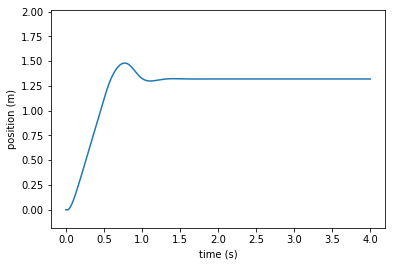

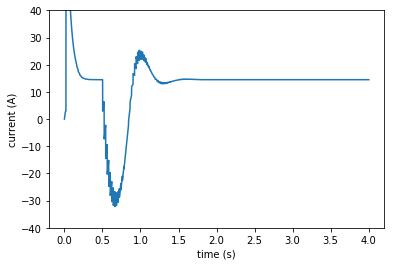

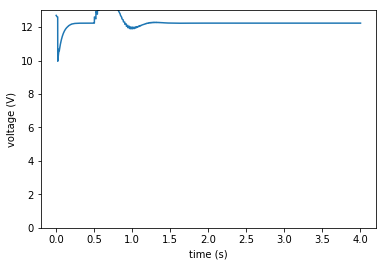

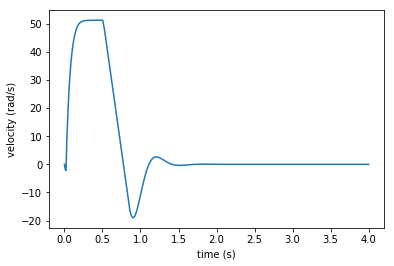

1.27
1.3192586826408956


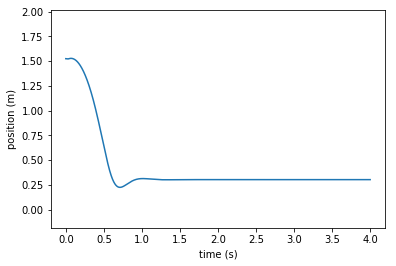

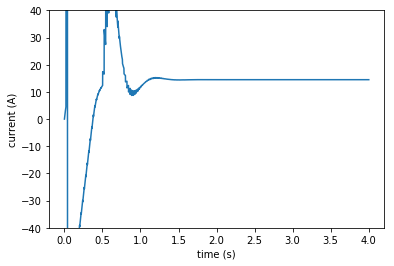

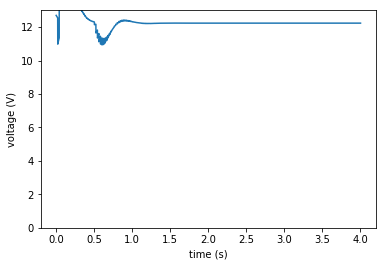

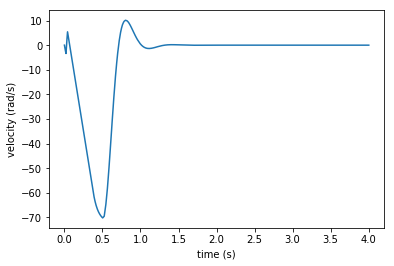

0.254
0.3032586825949181


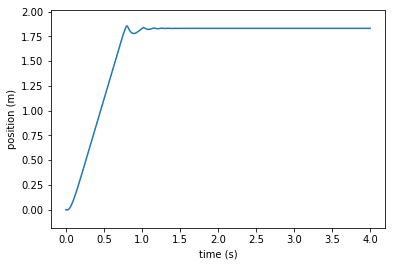

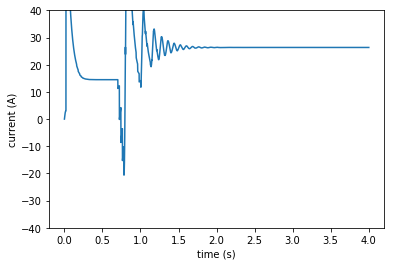

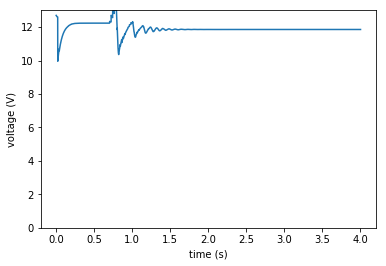

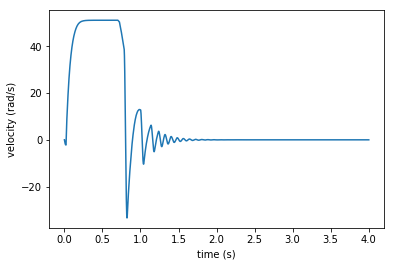

1.8288
1.8300994837250064


In [19]:
class Elevator(frccnt.System):
    def __init__(self, dt):
        state_labels = [
            ("position", "m"),
            ("velocity", "m/s"),
        ]
        u_labels = [("voltage", "V")]
        self.set_plot_labels(state_labels, u_labels)
        self.DT = dt
        self.radius = r = inch_to_meter(2)
        self.j = j = inertials.solid_cylinder(0.12, r) # moment of inertia of sprocket
        self.m1=m1 = lbs_to_kg(10)
        self.m2 = m2 = lbs_to_kg(30)
        
        self.motor_system = ms = motors.MotorSystem(motor=motors.neo, motor_count=2, gearing_ratio=10)
        Ka = j * ms.motor.resistance() / (2 * r * ms.motor.ktorque() * ms.motor_count * ms.gearing_ratio)
        Kv = ms.motor.kspeed() * ms.gearing_ratio / 2 / r
        self.Ks = Ks = ms.motor.resistance() * r * g * (m1 + 2 * m2) / (ms.motor.ktorque() * ms.motor_count * ms.gearing_ratio)
        A = numpy.array([
            [0, 1],
            [0, -Kv/Ka],
        ])
        B = numpy.array([
            [0],
            [1/Ka],
        ])
        C = numpy.array([
            [1, 0],
        ])
        D = numpy.zeros(shape=(1,1))
        
        self.model = control.ss(A, B, C, D)
        
        self.u_min = u_min = numpy.matrix([[-12.0]])
        self.u_max = u_max = numpy.matrix([[12.0]])
        
        
        frccnt.System.__init__(self, self.model, u_min, u_max, dt)
        
        q = [0.02, 0.4]
        r = [12.0]
        self.design_dlqr_controller(q, r)
        self.design_two_state_feedforward(q, r)

        q_pos = 0.05
        q_vel = 1.0
        r_pos = 0.0001
        self.design_kalman_filter([q_pos, q_vel], [r_pos])
    
    def make_sim(self, init, periodic, starting_pos):
        return ElevatorSimulation(
            starting_position_m=starting_pos,
            max_height_m=inch_to_meter(72),
            sprocket_radius_m=self.radius,
            robot_mass_kg=lbs_to_kg(154),
            stage1_mass_kg=lbs_to_kg(self.m1),
            stage2_mass_kg=lbs_to_kg(self.m2),
            stage3_mass_kg=lbs_to_kg(0.0),
            stage1_counterweighting_n=lbs_to_N(.0),
            stage2_counterweighting_n=lbs_to_N(0.0),
            friction_force_N=0,
            pulls_down = False,
            init=init,
            battery_voltage=12.7,
            periodic=periodic,
            periodic_period=self.DT,
            pid_sample_rate_s=0.001,
            gearbox_efficiency=1,
            motor_system=self.motor_system,
            dt_s=0.001,
        )
    def run_sim(self, starting_pos, setpoint):
        def init(state):
            state.u = numpy.zeros(shape=(self.sysd.B.shape[1], 1))
            state.u_offset = numpy.zeros(shape=state.u.shape)
            state.u_offset[0,0] = -self.Ks
            state.y = numpy.zeros((self.sysd.C.shape[0], 1))
            state.r = numpy.zeros((self.sysd.A.shape[0], 1))
            state.x_hat = numpy.zeros((self.sysd.A.shape[0], 1))
            state.Ainv = numpy.linalg.inv(self.sysd.A)
            
        def update_input(state, next_r):
            state.u = self.K @ (state.r - state.x_hat)
            uff = self.Kff @ (next_r  - self.sysd.A @ state.r)
            state.r = next_r
            state.u = numpy.clip(state.u + uff - state.u_offset, self.u_min, self.u_max)
            
        def periodic(state):
            setpoint_pos = setpoint
            state.x_hat += state.Ainv @ self.L @ (state.y - self.sysd.C @ state.x_hat - self.sysd.D @ state.u)
            update_input(state, numpy.array([[setpoint_pos, 0]]).T)
            state.motor.set(state.u[0,0] / state.voltage)
            state.y[0,0] = state.x
            state.x_hat = self.sysd.A @ state.x_hat + self.sysd.B @ state.u
            
        sim = self.make_sim(init, periodic,starting_pos)
        sim.run_lift_sim(timeout=4)
        return sim
        
        
e = Elevator(0.02)
sim = e.run_sim(0, inch_to_meter(50))
plot_position(sim)
plot_current(sim)
plot_voltage(sim)
plot_velocity(sim)
print(inch_to_meter(50))
print(sim.xs[-1])

sim = e.run_sim(inch_to_meter(60), inch_to_meter(10))
plot_position(sim)
plot_current(sim)
plot_voltage(sim)
plot_velocity(sim)
print(inch_to_meter(10))
print(sim.xs[-1])

e = Elevator(0.02)
sim = e.run_sim(0, inch_to_meter(72))
plot_position(sim)
plot_current(sim)
plot_voltage(sim)
plot_velocity(sim)
print(inch_to_meter(72))
print(sim.xs[-1])